In [1]:
from math import sqrt, floor, ceil

import matplotlib.pyplot as plt
from matplotlib import animation as plt_animation
import numpy as np
from math import exp
from IPython.display import HTML

In [2]:
np.random.seed(42)

In [3]:
def surface_function(x, y):  
    
    result = (
            3*(1-x)**2*exp(-x**2 - (y+1)**2)
            - 10*(x/5 - x**3 - y**5)*exp(-x**2-y**2)
            - 1/3*exp(-(x+1)**2 - y**2)
    )

    return result

In [4]:
class ParticleSwarm:
    def __init__(self,
                 target_function,
                 n_particles,
                 c1, c2,
                 w_min, w_max,
                 v_max,
                 n_iterations,
                 x_bounds, y_bounds,
                 random_initialisation = True,
                 position_cap = True,
                 velocity_cap = True):
        
        self.target_function = target_function
        
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        
        self.c1, self.c2 = c1, c2                             # cognitive and social component coefficiants
        self.w_min, self.w_max = w_min, w_max                 # bounds for inertia weight
        self.w = w_max                                        # starting intertia weight
        self.v_max = v_max                                    # max velocity
        self.x_bounds, self.y_bounds = x_bounds, y_bounds     # lower and upper bounds for the x and y axies
        
        self.particles_x = np.empty([n_particles, 2])         # vector of particle locations [n_particles, 2]
        self.particles_v = np.empty([n_particles, 2])         # vector of particle velocities [n_particles, 2]
        self.particles_pb = np.empty([n_particles, 2])        # vector of coordinates for personal bests [n_particles, 2]
        self.particles_gb = np.empty([2])                     # vector of coordinates for global best [2]
        
        self.particles_x_target = np.empty([n_particles])     # vector of values for current positions [n_particles,]
        self.particles_pb_target = np.empty([n_particles])    # vector of values for personal bests [n_particles,]
        self.particles_gb_target = None                       # a single value for global best value
        
        self.position_cap = position_cap                      # if True, will not allow particles to venture outside planting x, y bounds
        self.velocity_cap = velocity_cap                      # if True, will not allow particles velocity to exceed -+ v_max (on any axis)
        
        self.initialize_particles(x_bounds, y_bounds, random_initialisation)
        
    def initialize_particles(self, x_bounds, y_bounds, random_initialisation):
        """ 
        initiate the particles:
        1.) Planst the particles either randomly or in the uniform grid
        2.) Randomly sets their velocity vectors
        3.) Randomly sets their personal best points
        4.) Randomly sets the global best point
        """
        # setting the initial particle locations
        if random_initialisation:
            self.particles_x[:, 0] = np.random.uniform(*x_bounds, size = self.n_particles)
            self.particles_x[:, 1] = np.random.uniform(*y_bounds, size = self.n_particles)
        else:
            
            # initially plant all the points in the middle
            self.particles_x[:] = np.array([[sum(x_bounds) / 2, sum(y_bounds) / 2]])
            
            # will plant this^2 ammount of particles in a uniform grid
            max_full_grid_dim = floor(sqrt(self.n_particles)) 

            self.particles_x[:max_full_grid_dim**2] = np.array([
                [i, j]
                for i in np.linspace(*x_bounds, max_full_grid_dim)
                    for j in np.linspace(*y_bounds, max_full_grid_dim)
            ])
            
        # setting the initial velocity vectors
        self.particle_v = np.random.rand(self.n_particles, 2)
        
        # setting the initial personal best points & values
        self.particles_pb = np.random.rand(self.n_particles, 2) * self.v_max
        self.particles_pb_target[:] = np.Inf
        
        # setting the initial global best point
        self.particles_gb = np.zeros(2)
        self.particles_gb_target = np.Inf
        
    def sample_iteration(self):
        """
        Return the current position of the particles
        """
        
        return self.particles_x
        
    def simulate(self):
        """
        Runs the simulation for self.n_iterations,
        Works as a python generator and yields particle positions each iteration
        """
        for iteration_n in range(1, self.n_iterations + 1):
            
            # updating target values for each particle
            self.particle_x_target = self.target_function(self.particles_x[:,0], self.particles_x[:,1])
            
            # updating personal bests
            personal_best_mask = (self.particle_x_target < self.particles_pb_target)
            self.particles_pb_target[personal_best_mask] = self.particle_x_target[personal_best_mask]
            self.particles_pb[personal_best_mask] = self.particles_x[personal_best_mask]
            
            # updating global best
            iteration_lowest_value_index = np.argmin(self.particles_pb_target)        
            if self.particles_pb_target[iteration_lowest_value_index] < self.particles_gb_target:
                self.particles_gb_target = self.particles_pb_target[iteration_lowest_value_index]
                self.particles_gb = self.particles_pb[iteration_lowest_value_index]
            
            
            # updating the inertia weight linearly
            self.w = self.w_max - iteration_n * ((self.w_max - self.w_min) / self.n_iterations)
            
            # updating particle velocity vectors
            self.particles_v = (
                self.w * self.particles_v                                               # inertia
                + self.c1 * np.random.rand() * (self.particles_pb - self.particles_x)   # cognitive component
                + self.c2 * np.random.rand() * (self.particles_gb - self.particles_x)   # social component
            )
            
            # bouding velocity to v_max and -v_max
            if self.velocity_cap:
                overboard_velocity_masks = (self.particles_v > self.v_max, self.particles_v < -self.v_max)
                self.particles_v[overboard_velocity_masks[0]] = np.random.rand(np.sum(overboard_velocity_masks[0])) * v_max
                self.particles_v[overboard_velocity_masks[1]] = np.random.rand(np.sum(overboard_velocity_masks[1])) * -v_max
            
            # updating particle position vectors
            self.particles_x = self.particles_x + self.particles_v
            
            # bouding the points to the search space
            if self.position_cap:
                self.particles_x[:,0][self.particles_x[:, 0] > self.x_bounds[1]] = self.x_bounds[1]
                self.particles_x[:,0][self.particles_x[:, 0] < self.x_bounds[0]] = self.x_bounds[0]

                self.particles_x[:,1][self.particles_x[:, 1] > self.y_bounds[1]] = self.y_bounds[1]
                self.particles_x[:,1][self.particles_x[:, 1] < self.y_bounds[0]] = self.y_bounds[0]
            
            yield self.particles_x

In [5]:
class ScatterPlotAnimator:
    def __init__(
        self,
        target_function,
        x_bounds,
        y_bounds,
        simulation_object,
        frame_n,
        title = "",
        frame_interval = 50):
        
        self.target_function = target_function        # vectorized target function
        
        self.frame_n = frame_n                        # how many frames to render
        self.frame_interval = frame_interval          # time interval between frames
        
        self.simulation_object = simulation_object    # object that generates point data
        self.title = title                            # Title string for the plot                  
        
        self.x_bounds = x_bounds                      # x bounds for the plot
        self.y_bounds = y_bounds                      # y bounds for the plot
        self.figure, self.axis = plt.subplots(figsize = (10,10))
        
        # adding initial points on the plot
        points = self.simulation_object.sample_iteration()
        self.scatter = self.axis.scatter(points[:, 0], points[:,1], s = 8, c = "black")

        self.animation = plt_animation.FuncAnimation(self.figure,
                                                  self.update,
                                                  interval = self.frame_interval,
                                                  frames = self.simulation_object.simulate(),
                                                  save_count = self.frame_n,
                                                  init_func=self.setup_plot,
                                                  blit=True)
        
    def setup_plot(self):
        """
        Setups the initial visual plot
        """
        # set the contour plot
        x = np.linspace(*self.x_bounds, 100)
        y = np.linspace(*self.y_bounds, 100)

        xx, yy = np.meshgrid(x, y)
        zz = self.target_function(xx, yy)
        
        self.axis.contour(xx, yy, zz, levels = 15)
        
        # name the axis
        self.axis.set_xlabel("x")
        self.axis.set_ylabel("y")
        
        # add title
        self.axis.set_title(self.title)
        
        return (self.scatter,)
                    
    def update(self, points):
        """
        Updates the plot by re-drawing points
        """
        self.scatter.set_offsets(points)
        
        return (self.scatter,)
    
    def render(self):
        """
        Renders the animation to be displayed in jupyter notebooks
        """
        return HTML(self.animation.to_html5_video())

In [6]:
# vectorizing target function (so it could work with numpy arrays)
target_function = np.vectorize(surface_function) # vectorized target function

# defining simulation hyperarameters
n_particles = 36
n_iterations = 100

c1, c2 = 2, 2                     # cognitive and social component coefficiants
w_min, w_max = 0.4, 0.9           # bounds for the inertia coefficiant
v_max = 6                         # max possible velocity (to cap speeding particles)

particle_seed_x_bounds = (-5, 5)  # area bounds for seeding the particles on the x axis
particle_seed_y_bounds = (-5,5)   # area bounds for seeding the particles on the y axis

random_initialisation = False     # whether to plant particles in a random or grid fashion
position_cap = True               # if True, will not allow particles to venture outside planting x, y bounds
                                  # if False, some particles may go into -+Inf and crash
velocity_cap = True               # if True, will not allow particles velocity to exceed +- v_max
                                  # if False, some particles may wander very long due to large inertia

# defining visualisation hyperparameters
title = f"w = [{w_min}, {w_max}], c1 = {c1}, c2 = {c2}"

plot_x_bounds = (-5, 5)           # x axis bounds for the plot
plot_y_bounds = (-5, 5)           # y axis bounds for the plot

frame_interval = 48               # time interval between frames (smaller = faster animation)

In [7]:
# making the simulation object that will generate particle locations for each iteration
swarm_simulation = ParticleSwarm(
    target_function = target_function,
    n_particles = n_particles,
    c1 = c1, c2 = c2,
    w_min = w_min, w_max = w_max,
    v_max = v_max,
    n_iterations = n_iterations,
    x_bounds = particle_seed_x_bounds,
    y_bounds = particle_seed_y_bounds,
    random_initialisation = random_initialisation,
    position_cap = position_cap,
    velocity_cap = velocity_cap
)

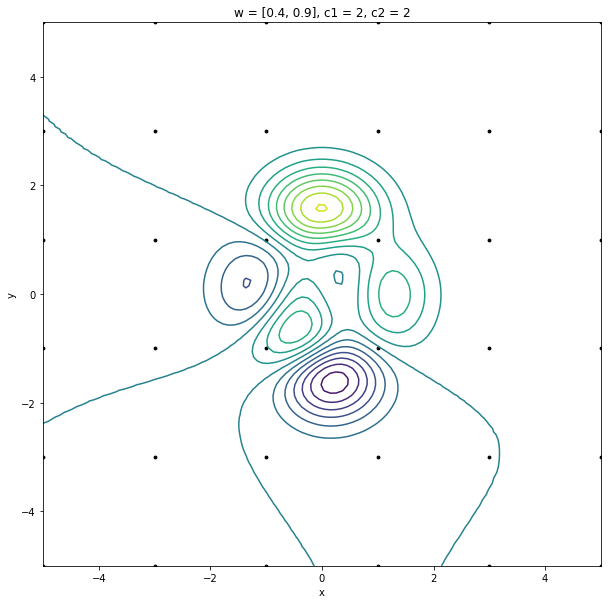

In [8]:
# making Animator object that will animate the scatter plot
animation = ScatterPlotAnimator(
    title = title,
    target_function = target_function,
    x_bounds = plot_x_bounds,
    y_bounds = plot_y_bounds,
    simulation_object = swarm_simulation,
    frame_n = n_iterations,
    frame_interval = frame_interval
)

In [10]:
animation.render()